In [1]:
import glob
import os
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.metrics import r2_score
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Import data

In [2]:
processed_folder = '..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior'

# Find all DBF files in the folder
shp_files = [
    f for f in glob.glob(os.path.join(processed_folder, '*.shp'))
    if '_log' not in os.path.basename(f)
]

for shp_file in shp_files:
    print(f"Verifying {shp_file}...")

Verifying ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_final.shp...
Verifying ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model.shp...


In [3]:
dataframes = {}

for file in shp_files:
    df_name = os.path.splitext(os.path.basename(file))[0]  # nome do arquivo sem .shp
    dataframes[df_name] = gpd.read_file(file)

c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [4]:
cols = [
    "inidoy","enddoy","ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av","aspect_av",
    "landform","fuel_model","f_load_av","land_use","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "Haines_av","wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

for name, df in dataframes.items():
    valid_cols = [c for c in cols if c in df.columns]
    df[valid_cols] = df[valid_cols].replace([-1, -999], np.nan)
    dataframes[name] = df

In [5]:
#log transformation

cols_log = [
    "ros_p","1_3y_fir_p","3_8y_fir_p","8_ny_fir_p","elev_av",
    "f_load_av","CBH_m_av","HigCC_p_av","LowCC_p_av",
    "MidCC_p_av","TotCC_p_av","BLH_m_av","Cape_av","Cin_av","gp_m2s2_av","t_2m_C_av",
    "d_2m_C_av","sP_hPa_av","wv10_kh_av","wdir10_av","wv100_k_av","wdir100_av","rh_2m_av",
    "VPD_Pa_av","dfmc_av","sW_1m_av","sW_3m_av","LCL_hPa_av","LCL_m_av","HDW_av",
    "wSv_9_av","wSdir_9_av","wSv_7_av","wSdir_7_av","wSv_5_av","wSdir_5_av",
    "wSv_1_av","wSdir_1_av","gT_s_9_av","gT_9_8_av","gT_8_7_av","gT_7_5_av","gT_5_3_av",
    "CMLG_av","LFC_hPa_av","CCL_hPa_av","EL_m_av","VentIdx_av","LiftIdx_av","gp_950_av",
    "gp_850_av","gp_700_av","gp_500_av","gp_300_av","rh_950_av","rh_850_av","rh_700_av",
    "rh_500_av","rh_300_av","t_950_av","t_850_av","t_700_av","t_500_av","t_300_av",
    "vwv_950_av","vwv_850_av","vwv_700_av","vwv_500_av","vwv_300_av","wv_950_av",
    "wv_850_av","wv_700_av","wv_500_av","wv_300_av","wdi_950_av","wdi_850_av","wdi_700_av",
    "wdi_500_av","wdi_300_av","wv_10_av","wdi_10_av","wv_100_av","wdi_100_av","BLH_m_rt",
    "Recirc","CircVar","CircStd_dg","ros_p_lg1","ros_p_lg2","ros_p_lg3","ros_p_lg4",
    "ros_p_lg5","ros_p_lg6","ros_p_lg7","ros_p_lg8","ros_p_lg9","ros_p_lg10","duration"
]

for shp_file in shp_files:
    base = os.path.splitext(os.path.basename(shp_file))[0]
    print(f"Importing {base}...")

    # Carregar shapefile completo
    gdf = gpd.read_file(shp_file)

    # Selecionar apenas colunas da lista que existam no GDF
    valid_cols = [c for c in cols_log if c in gdf.columns]

    # Substituir valores inválidos antes do log
    gdf[valid_cols] = gdf[valid_cols].replace([-1, -999, 0], np.nan)

    # Aplicar log natural APENAS às colunas selecionadas
    gdf[valid_cols] = np.log(gdf[valid_cols])

    # Guardar com sufixo _log
    output_path = os.path.join(processed_folder, f"{base}_log.shp")
    print(f"Saving {output_path}...")
    gdf.to_file(output_path)

print("✅ All files processed.")

Importing PT-FireProg_v2.1_L2_final...


c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Saving ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_final_log.shp...
Importing PT-FireProg_v2.1_L2_model...


c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Saving ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model_log.shp...
✅ All files processed.


In [6]:
shp_files = glob.glob(os.path.join(processed_folder, '*.shp'))

for shp_file in shp_files:
    print(f"Verifying {shp_file}...")

for file in shp_files:
    df_name = os.path.splitext(os.path.basename(file))[0]  # nome do arquivo sem .shp
    dataframes[df_name] = gpd.read_file(file)

Verifying ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_final.shp...
Verifying ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_final_log.shp...
Verifying ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model.shp...
Verifying ..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model_log.shp...


### Plot ROS_P Distribution


Analyzing PT-FireProg_v2.1_L2_final...


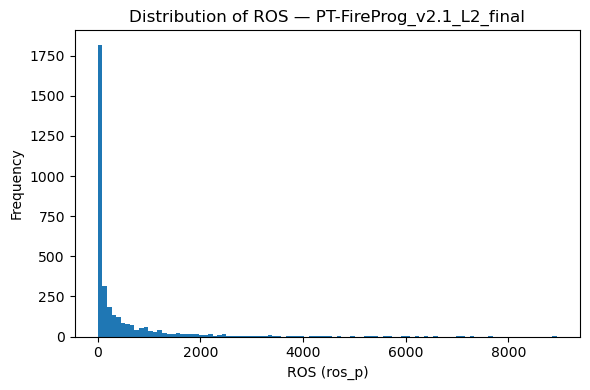

D’Agostino–Pearson Normality Test for ros_p
Statistic: 2892.3144
p-value: 0.0000e+00
Reject H₀ (data is likely not normal).

Analyzing PT-FireProg_v2.1_L2_model...


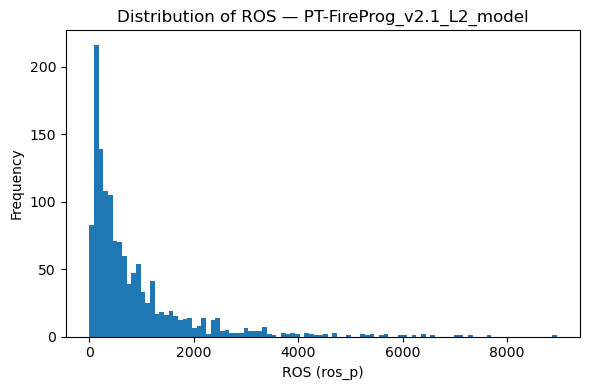

D’Agostino–Pearson Normality Test for ros_p
Statistic: 862.3172
p-value: 5.6259e-188
Reject H₀ (data is likely not normal).

Analyzing PT-FireProg_v2.1_L2_final_log...


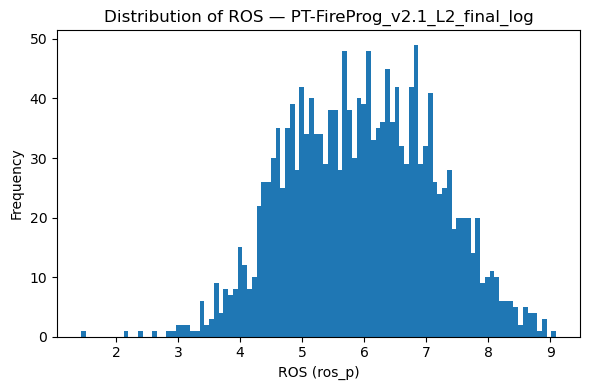

D’Agostino–Pearson Normality Test for ros_p
Statistic: 17.2586
p-value: 1.7879e-04
Reject H₀ (data is likely not normal).

Analyzing PT-FireProg_v2.1_L2_model_log...


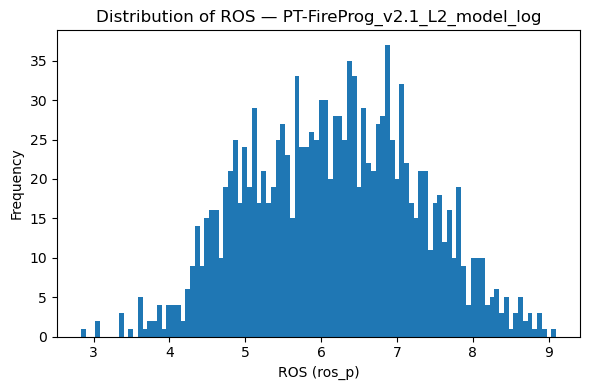

D’Agostino–Pearson Normality Test for ros_p
Statistic: 24.7190
p-value: 4.2887e-06
Reject H₀ (data is likely not normal).


In [7]:
for name, df in dataframes.items():
    print(f"\nAnalyzing {name}...")

    if "ros_p" not in df.columns:
        print("Skipped — 'ros_p' column not found.")
        continue

    # Convert ros_p to numeric and drop NaNs
    ros_data = pd.to_numeric(df["ros_p"], errors="coerce").dropna()

    if len(ros_data) == 0:
        print("Skipped — no valid 'ros_p' values.")
        continue

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(ros_data, bins=100)
    plt.title(f"Distribution of ROS — {name}")
    plt.xlabel("ROS (ros_p)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Perform D’Agostino–Pearson normality test
    stat, p_value = stats.normaltest(ros_data)

    print("D’Agostino–Pearson Normality Test for ros_p")
    print(f"Statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4e}")

    if p_value > 0.05:
        print("Fail to reject H₀ (data appears normal).")
    else:
        print("Reject H₀ (data is likely not normal).")

### Compute descriptive statistics (mean, median, quartiles, std, skewness, kurtosis)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def _to_numeric_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors='coerce')

# ========== DEFINE CATEGORICAL VARIABLES HERE ==========
categorical_variables = [
    'Haines_av',
    'burn_perio',
    'land_use',
    'zp_link',
    'year',
    "fuel_model",
    "landform"
    # Add your categorical variable names here
]
# =======================================================

# Dictionary to hold statistics for each file
all_stats = {}

for name, df in dataframes.items():
    print(f"Processing descriptive statistics for {name}...")

    # Convert object columns that contain numeric data
    for col in df.columns:
        if df[col].dtype == 'object' and col not in categorical_variables:
            converted = pd.to_numeric(df[col], errors='coerce')
            if not converted.isna().all():
                df[col] = converted
    
    # Identify categorical columns that exist in this dataframe
    categorical_cols = [col for col in categorical_variables if col in df.columns]
    
    # Select numeric columns only (exclude 'sdate' and categorical variables)
    numeric_cols = df.select_dtypes(include=['number']).columns.difference(['sdate'] + categorical_cols)
    
    all_cols = list(numeric_cols) + categorical_cols
    
    if len(all_cols) == 0:
        print(f"No valid columns found in {name}. Skipping.")
        continue
    
    # Create stats dataframe with all columns
    desc_stats = pd.DataFrame(index=all_cols)
    
    # ========== NUMERIC VARIABLES ==========
    if len(numeric_cols) > 0:
        desc_stats.loc[numeric_cols, 'mean'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).mean())
        desc_stats.loc[numeric_cols, 'median'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).median())
        desc_stats.loc[numeric_cols, 'std'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).std())
        desc_stats.loc[numeric_cols, 'var'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).var())
        desc_stats.loc[numeric_cols, 'q05'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.05))
        desc_stats.loc[numeric_cols, 'q25'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.25))
        desc_stats.loc[numeric_cols, 'q75'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.75))
        desc_stats.loc[numeric_cols, 'q95'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).quantile(0.95))
        desc_stats.loc[numeric_cols, 'min'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).min())
        desc_stats.loc[numeric_cols, 'max'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).max())
        desc_stats.loc[numeric_cols, 'skewness'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).skew())
        desc_stats.loc[numeric_cols, 'kurtosis'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).kurtosis())
        desc_stats.loc[numeric_cols, 'n_missing'] = df[numeric_cols].apply(lambda col: _to_numeric_series(col).isna().sum())
        desc_stats.loc[numeric_cols, 'AIQ'] = desc_stats.loc[numeric_cols, 'q75'] - desc_stats.loc[numeric_cols, 'q25']
    
    # ========== CATEGORICAL VARIABLES ==========
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            desc_stats.loc[col, 'n_unique'] = df[col].nunique()
            desc_stats.loc[col, 'mode'] = df[col].mode()[0] if len(df[col].mode()) > 0 else np.nan
            desc_stats.loc[col, 'mode_freq'] = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else np.nan
            desc_stats.loc[col, 'mode_pct'] = (desc_stats.loc[col, 'mode_freq'] / len(df)) * 100 if pd.notna(desc_stats.loc[col, 'mode_freq']) else np.nan
            desc_stats.loc[col, 'n_missing'] = df[col].isna().sum()
    
    # ========== R² with ros_p ==========
    if 'ros_p' in df.columns:
        ros_series = pd.to_numeric(df['ros_p'], errors='coerce')
        ros_series = ros_series.replace([np.inf, -np.inf], np.nan)
        
        # For numeric variables: Pearson correlation
        for col in numeric_cols:
            if col != 'ros_p':
                col_series = pd.to_numeric(df[col], errors='coerce')
                valid_idx = ros_series.notna() & col_series.notna()
                if valid_idx.sum() > 1:
                    corr = ros_series[valid_idx].corr(col_series[valid_idx])
                    desc_stats.loc[col, 'R2_ros_p'] = corr ** 2
                else:
                    desc_stats.loc[col, 'R2_ros_p'] = np.nan
        
        # For categorical variables: Eta-squared (effect size from ANOVA)
        for col in categorical_cols:
            try:
                valid_idx = ros_series.notna() & df[col].notna()
                if valid_idx.sum() > 1:
                    groups = df.loc[valid_idx, col]
                    values = ros_series[valid_idx]
                    
                    # Need at least 2 groups
                    if groups.nunique() < 2:
                        desc_stats.loc[col, 'R2_ros_p'] = np.nan
                        continue
                    
                    # Calculate eta-squared (proportion of variance explained)
                    group_means = values.groupby(groups).mean()
                    overall_mean = values.mean()
                    
                    ss_between = sum(values.groupby(groups).size() * (group_means - overall_mean) ** 2)
                    ss_total = sum((values - overall_mean) ** 2)
                    
                    if ss_total > 0:
                        eta_squared = ss_between / ss_total
                        desc_stats.loc[col, 'R2_ros_p'] = eta_squared
                    else:
                        desc_stats.loc[col, 'R2_ros_p'] = np.nan
                else:
                    desc_stats.loc[col, 'R2_ros_p'] = np.nan
            except Exception as e:
                print(f"R² calculation failed for categorical {col}: {e}")
                desc_stats.loc[col, 'R2_ros_p'] = np.nan
    else:
        desc_stats['R2_ros_p'] = np.nan
    
    # ========== VIF calculation ==========
    if 'ros_p' in df.columns:
        for col in all_cols:
            if col != 'ros_p' and col in desc_stats.index:
                r2 = desc_stats.loc[col, 'R2_ros_p']
                if pd.notna(r2) and r2 < 1.0:
                    desc_stats.loc[col, 'VIF'] = 1.0 / (1.0 - r2)
                else:
                    desc_stats.loc[col, 'VIF'] = np.nan
        
        # Set ros_p VIF to NaN
        if 'ros_p' in desc_stats.index:
            desc_stats.loc['ros_p', 'VIF'] = np.nan
    else:
        print(f"'ros_p' not found in {name}")
        desc_stats['VIF'] = np.nan
    
    # Add variable type column
    desc_stats['var_type'] = 'numeric'
    desc_stats.loc[categorical_cols, 'var_type'] = 'categorical'
    
    # Final column ordering
    numeric_stat_cols = ['mean', 'median', 'std', 'var', 'q05', 'q25', 'q75', 'q95', 'min', 'max', 'AIQ', 'skewness', 'kurtosis']
    categorical_stat_cols = ['n_unique', 'mode', 'mode_freq', 'mode_pct']
    common_cols = ['n_missing', 'R2_ros_p', 'VIF', 'var_type']
    
    final_cols = numeric_stat_cols + categorical_stat_cols + common_cols
    desc_stats = desc_stats[[col for col in final_cols if col in desc_stats.columns]]
    
    desc_stats.loc['sdate'] = np.nan
    
    all_stats[name] = desc_stats
    
    # Save to CSV
    path = Path("../../Data/Data_Exploration")
    path.mkdir(parents=True, exist_ok=True)
    output_path = path / f'descriptive_stats_{name}.csv'
    desc_stats.to_csv(output_path)
    print(f"Saved {output_path}")

print("All descriptive statistics have been generated and saved.")

Processing descriptive statistics for PT-FireProg_v2.1_L2_final...


### Data transformation

### Recompute descriptive statistics (mean, median, quartiles, std, skewness, kurtosis) for transformed dataset

## Fazer plots dashboard

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display, clear_output

# Carregar DataFrame transformado
df_transformed = dataframes["PT-FireProg_v2.1_L2_model_log"]

# Selecionar apenas colunas numéricas
numeric_df = df_transformed.select_dtypes(include=[np.number])
if numeric_df.empty:
    raise ValueError("No numeric columns found in the DataFrame.")

# Preparar dados brutos
original_data = {}
for col in numeric_df.columns:
    data = numeric_df[col].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) > 0:
        original_data[col] = data.values

# Widgets
checkboxes = {
    col: widgets.Checkbox(value=False, description=col, indent=False)
    for col in original_data.keys()
}
select_all_btn = widgets.Button(description="Select All", button_style='info', icon='check')
deselect_all_btn = widgets.Button(description="Deselect All", button_style='warning', icon='times')
output = widgets.Output()

# Funções
def update_plot(*args):
    with output:
        clear_output(wait=True)
        selected = [col for col, cb in checkboxes.items() if cb.value]
        if not selected:
            print("No features selected. Please select at least one feature.")
            return
        
        n_cols = 2
        n_rows = int(np.ceil(len(selected) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
        axes = axes.flatten()
        
        for i, col in enumerate(selected):
            data = original_data[col]
            kde = stats.gaussian_kde(data)
            x = np.linspace(data.min(), data.max(), 2000)
            axes[i].plot(x, kde(x), lw=2, color='blue')
            axes[i].set_title(col)
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Density')
            axes[i].grid(True, linestyle='--', alpha=0.5)  # adiciona gridlines
        
        # Remover eixos extras
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        
        plt.tight_layout()
        plt.show()

def select_all(_):
    for cb in checkboxes.values():
        cb.value = True

def deselect_all(_):
    for cb in checkboxes.values():
        cb.value = False

# Bind eventos
for cb in checkboxes.values():
    cb.observe(update_plot, names='value')
select_all_btn.on_click(select_all)
deselect_all_btn.on_click(deselect_all)

# Layout
checkbox_container = VBox(
    list(checkboxes.values()),
    layout=Layout(
        height='250px',
        overflow_y='auto',
        border='1px solid #ccc',
        padding='10px'
    )
)

controls = VBox([
    widgets.HTML("<h3>Select Features to Plot Density Lines:</h3>"),
    HBox([select_all_btn, deselect_all_btn]),
    widgets.HTML("<b>Variables (scrollable):</b>"),
    checkbox_container
])

ui = VBox([controls, output])

# Exibir UI
display(ui)
update_plot()

isto ja sao transformações é mais sus

BEST TRANSFORMATION SELECTION (by R²)

ros_p_lg1 vs ros_p:
  Best transformation: Linear-Linear
  R² = 0.3755 | r = 0.6128 | p = 2.91e-101 | n = 972
  All R² values:
    Linear-Linear: R² = 0.3755 ← BEST
    Linear-LOG: R² = 0.2988
    LOG-Linear: R² = 0.2492
    LOG-LOG: R² = 0.3322

ros_p_lg2 vs ros_p:
  Best transformation: LOG-LOG
  R² = 0.3219 | r = 0.5674 | p = 5.03e-75 | n = 867
  All R² values:
    Linear-Linear: R² = 0.2791
    Linear-LOG: R² = 0.2572
    LOG-Linear: R² = 0.2323
    LOG-LOG: R² = 0.3219 ← BEST

ros_p_lg3 vs ros_p:
  Best transformation: Linear-Linear
  R² = 0.2646 | r = 0.5144 | p = 1.72e-52 | n = 759
  All R² values:
    Linear-Linear: R² = 0.2646 ← BEST
    Linear-LOG: R² = 0.2154
    LOG-Linear: R² = 0.1976
    LOG-LOG: R² = 0.2616

BLH_m_av vs ros_p:
  Best transformation: Linear-LOG
  R² = 0.0713 | r = 0.2670 | p = 1.51e-23 | n = 1355
  All R² values:
    Linear-Linear: R² = 0.0271
    Linear-LOG: R² = 0.0713 ← BEST
    LOG-Linear: R² = 0.0281
    LOG-LOG


Assessing normality for transformed columns in PT-FireProg_v2.1_L2_model...
No Yeo-Johnson transformed columns found in PT-FireProg_v2.1_L2_model.


NORMALITY TESTING FOR PT-FIREPROG_V2.1_L2_MODEL
Original shape: (1359, 105), Transformed shape: (1359, 105)


Normality testing: 100%|██████████| 105/105 [00:00<00:00, 1358.46it/s]


✓ Detailed normality results saved: normality_results_PT-FireProg_v2.1_L2_model.csv

Total numeric features tested: 105
Shapiro-Wilk normal: 5 (4.8%)
Jarque-Bera normal: 9 (8.6%)
D'Agostino-Pearson normal: 9 (8.6%)
All tests agree NORMAL: 5 (4.8%)
All tests agree NON-NORMAL: 96 (91.4%)
Tests disagree: 4


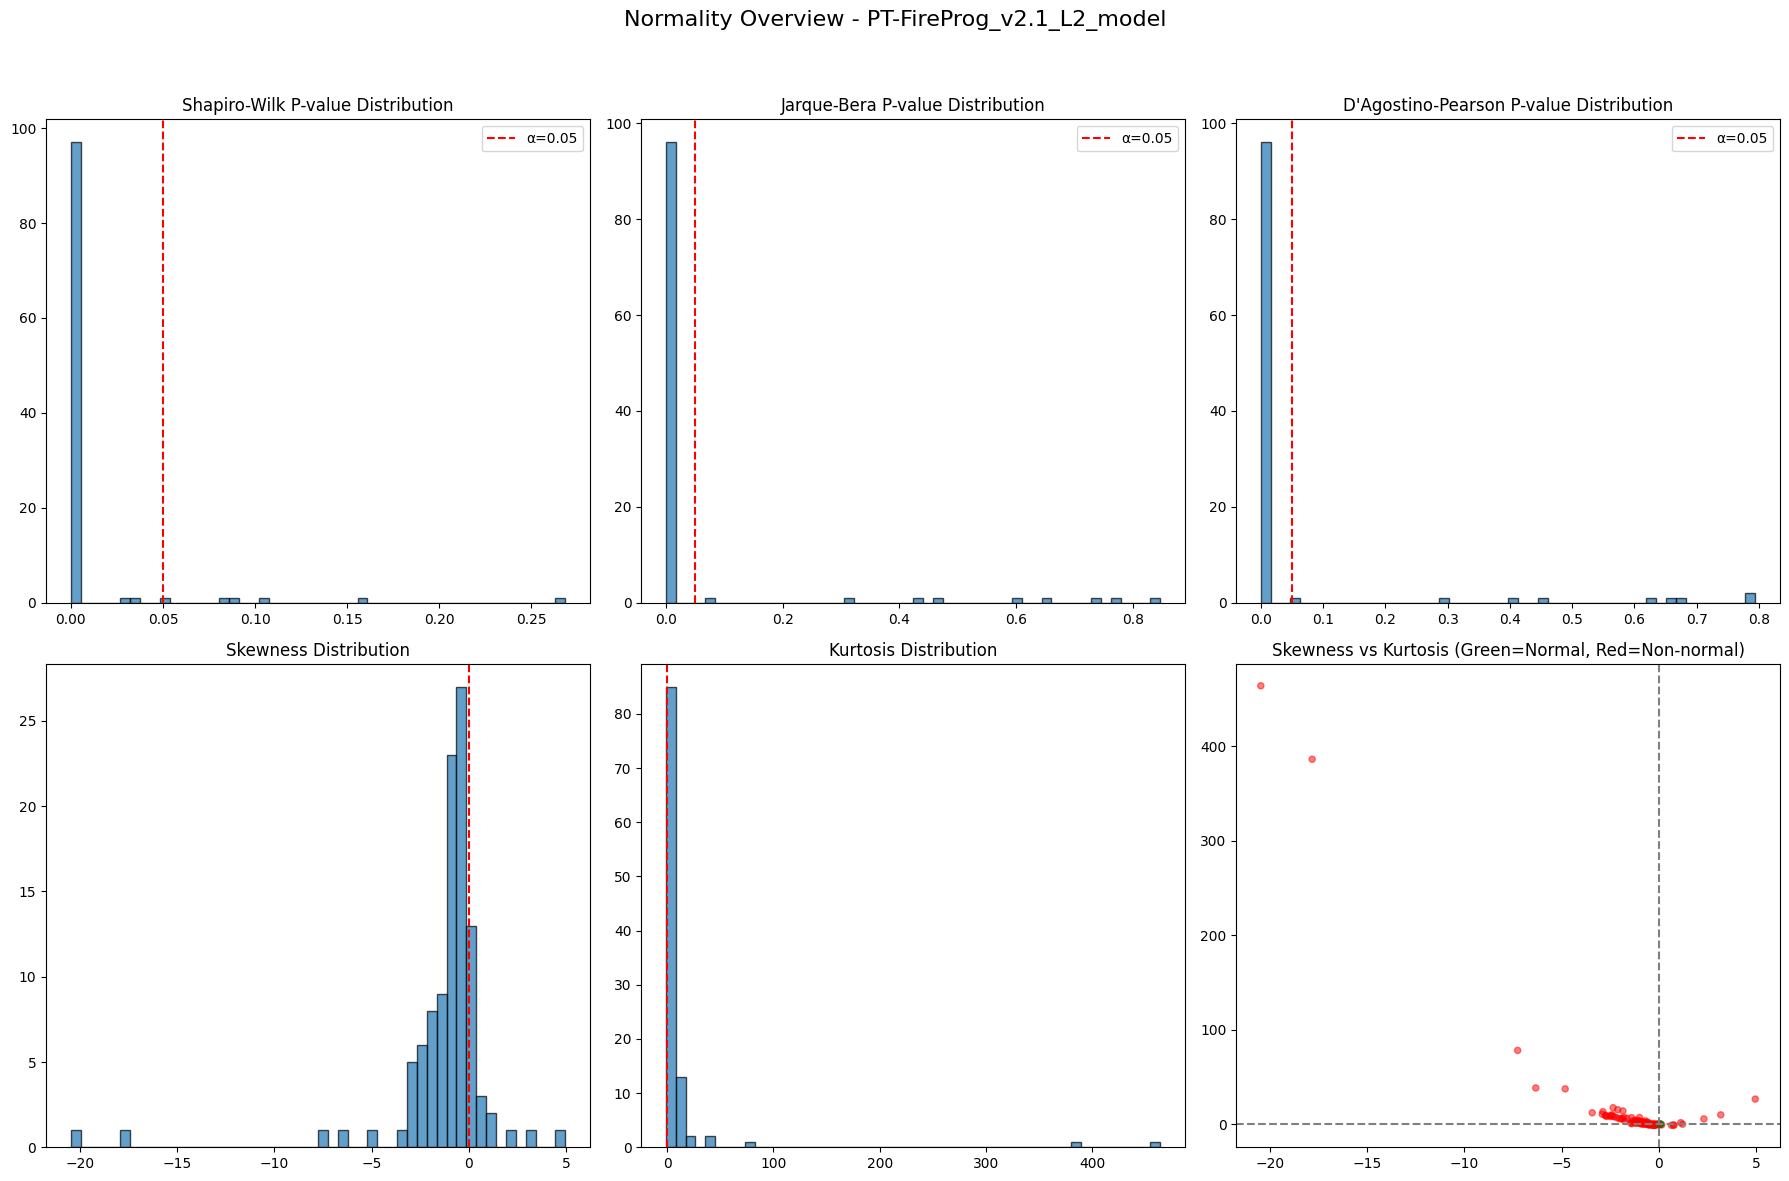

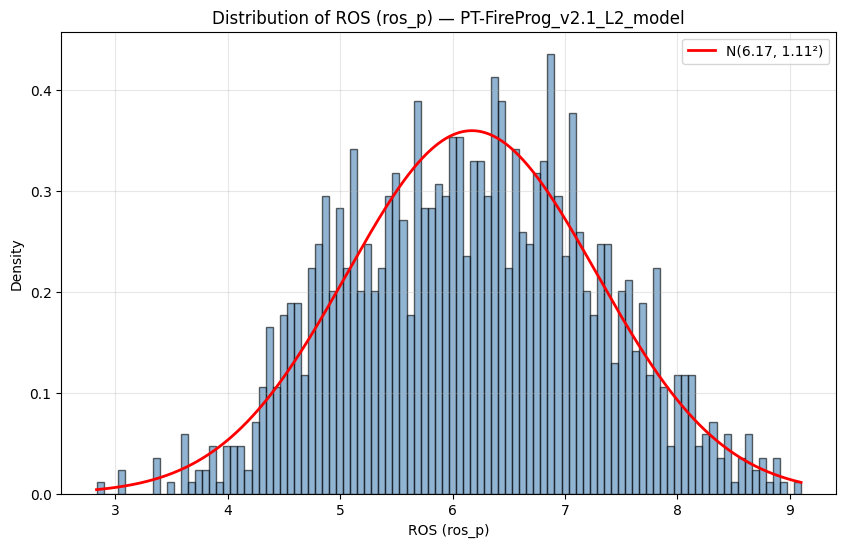

------------------------------------------------------------
Dataset: PT-FireProg_v2.1_L2_model
D’Agostino–Pearson Normality Test for ros_p
Statistic: 24.7190
p-value: 4.2887e-06
Reject H₀ — data likely not normal.


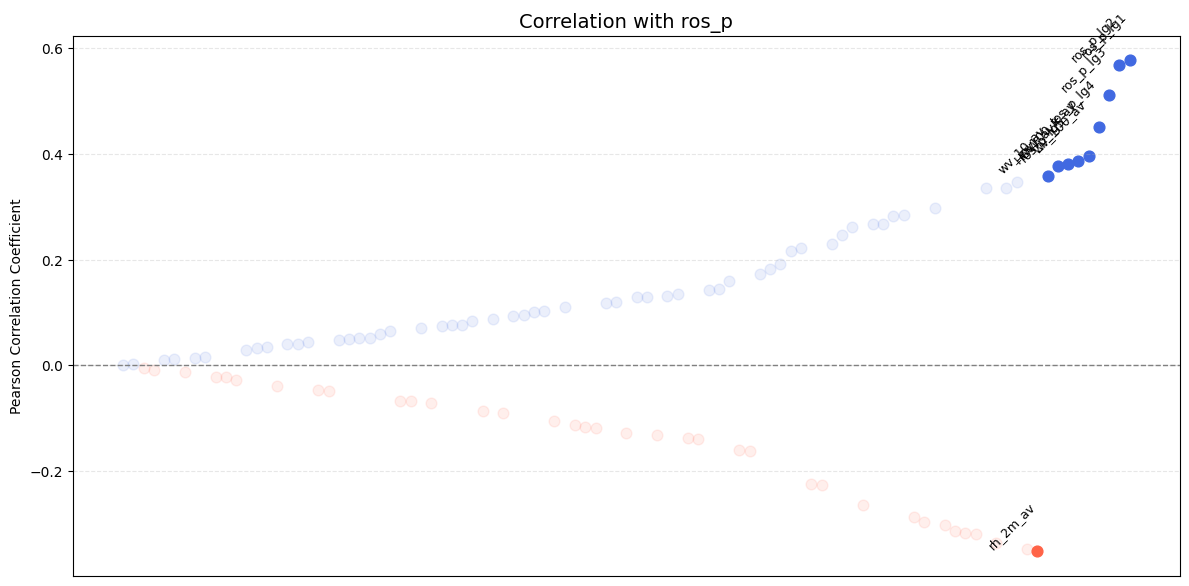

,Variable,correlation_with_ros_p
0,ros_p_lg1,0.576379
1,ros_p_lg2,0.567399
2,ros_p_lg3,0.511455
3,ros_p_lg4,0.449522
4,wv_100_av,0.395909
5,wv100_k_av,0.386102
6,ros_p_lg5,0.379767
7,HDW_av,0.377432
8,wv_10_av,0.358669
9,rh_2m_av,-0.351226


Total columns found: 105
Numeric columns to process: ['inidoy', 'enddoy', '1_3y_fir_p', '3_8y_fir_p', '8_ny_fir_p', 'elev_av', 'aspect_av', 'landform', 'fuel_model', 'f_load_av', 'land_use', 'CBH_m_av', 'HigCC_p_av', 'LowCC_p_av', 'MidCC_p_av', 'TotCC_p_av', 'BLH_m_av', 'Cape_av', 'Cin_av', 'gp_m2s2_av', 't_2m_C_av', 'd_2m_C_av', 'sP_hPa_av', 'wv10_kh_av', 'wdir10_av', 'wv100_k_av', 'wdir100_av', 'rh_2m_av', 'VPD_Pa_av', 'dfmc_av', 'sW_1m_av', 'sW_3m_av', 'LCL_hPa_av', 'LCL_m_av', 'HDW_av', 'Haines_av', 'wSv_9_av', 'wSdir_9_av', 'wSv_7_av', 'wSdir_7_av', 'wSv_5_av', 'wSdir_5_av', 'wSv_1_av', 'wSdir_1_av', 'gT_s_9_av', 'gT_9_8_av', 'gT_8_7_av', 'gT_7_5_av', 'gT_5_3_av', 'CMLG_av', 'LFC_hPa_av', 'CCL_hPa_av', 'EL_m_av', 'VentIdx_av', 'LiftIdx_av', 'gp_950_av', 'gp_850_av', 'gp_700_av', 'gp_500_av', 'gp_300_av', 'rh_950_av', 'rh_850_av', 'rh_700_av', 'rh_500_av', 'rh_300_av', 't_950_av', 't_850_av', 't_700_av', 't_500_av', 't_300_av', 'vwv_950_av', 'vwv_850_av', 'vwv_700_av', 'vwv_500_av'

/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1231: RuntimeWarning: overflow encountered in square
  s = s**2
